In [1]:
##필요한 라이브러리 import##
import numpy as np
from glob import glob
import random
import cv2                
import os
from pathlib import Path
from tqdm import tqdm
import torchvision
from torchvision import datasets
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F;
import torch.optim as optimizer
from PIL import ImageFile
from PIL import Image
import IPython
import matplotlib.pyplot as plt

In [2]:
##저는 로컬로 작업을 해서 경로명을 사진이 저장된 제 PC로 설정하였습니다
##colab에서 사용하실 경우 경로만 바꿔주셔서 데이터를 불러오시면 됩니다. 
import random
import numpy as np
from glob import glob

eye_train_files = np.array(glob("./Metastasis/train/*/*"))
eye_test_files = np.array(glob("./Metastasis//test/*/*"))

#eye_train_files = np.array(glob("C:/Users/BrainK/Downloads/glaucoma/train/*/*"))
#eye_test_files = np.array(glob("C:/Users/BrainK/Downloads/glaucoma/test/*/*"))



print('%d 개의 train set' % len(eye_train_files))
print('%d 개의 test set' % len(eye_test_files)) 
#보통 Train / Test / Validation 세트를 6:2:2로 나눕니다.
#폴더별로 나누셔도 되고 아니면 한 폴데에 클래스만 나누신 후 랜덤으로 선택하셔도 좋습니다.

70 개의 train set
23 개의 test set


In [3]:
##이미지를 로드하는 함수입니다
def image_loader(img_path, transform, use_cuda):
    image = Image.open(img_path).convert('RGB')
    img = transform(image)[:3,:,:].unsqueeze(0)
    if use_cuda:
        img = img.cuda()
    return img

In [4]:
def get_mean_std(dataset):
    meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
    stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print(meanR, meanG, meanB)
    print(stdR, stdG, stdB)

In [4]:
##분류되어있는 데이터를 각 폴더명에 맞게 분류하여 로드합니다

newpath = Path("./Metastasis/").expanduser()
#newpath = Path("C:/Users/BrainK/Downloads/glaucoma/").expanduser()

train_path = str(newpath.joinpath("train"))
valid_path = str(newpath.joinpath("test"))
test_path = str(newpath.joinpath("test"))

IMAGE_SIZE = 512,1024 #파일 크기를 입력해주시면 됩니다. 

MEANS = [0.5]
DEVIATIONS = [0.5]

# 데이터를 보강하고 tensor로 변환합니다.
train_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                transforms.ToTensor()])
test_transform =  transforms.Compose([transforms.Resize(IMAGE_SIZE), 
                        #transforms.CenterCrop(240), 
                        transforms.ToTensor(), 
                        transforms.Normalize(MEANS, DEVIATIONS)]) 

#각 폴더명에 맞게 불러옵니다
training = datasets.ImageFolder(train_path , transform=train_transform)
validation = datasets.ImageFolder(valid_path , transform=test_transform)
testing = datasets.ImageFolder(test_path , transform=test_transform)


train_batches = torch.utils.data.DataLoader(training, batch_size=32, shuffle=True, num_workers=0,pin_memory=True) #batch-size를 너무 작게 잡거나 크게 잡으면 학습이 제대로 진행되지 않을 가능성이 큽니다. 만약 GPU메모리가 부족하다면 batch size를 작게 사용하세요. 
valid_batches = torch.utils.data.DataLoader(validation, batch_size=2, shuffle=True, num_workers=0,pin_memory=True) #shuffle은 데이터셋을 무작위로 선택하여 학습하는 기능인데 True로 두었을때(적용했을때) 결과가 더 좋았습니다.
test_batches = torch.utils.data.DataLoader(testing, batch_size=8,num_workers=0,pin_memory=True)

In [8]:
get_mean_std(training)

0.9385255 0.9385255 0.9385255
0.10765342 0.10765342 0.10765342


In [8]:
##분류되어있는 데이터를 각 폴더명에 맞게 분류하여 로드합니다

newpath = Path("./Metastasis/").expanduser()
#newpath = Path("C:/Users/BrainK/Downloads/glaucoma/").expanduser()

train_path = str(newpath.joinpath("train"))
valid_path = str(newpath.joinpath("valid"))
test_path = str(newpath.joinpath("test"))

IMAGE_SIZE = 512,1024 #파일 크기를 입력해주시면 됩니다. 

MEANS = [0.9385255]
DEVIATIONS = [0.10765342]

#MEANS = [0.5,0.5,0.5]
#DEVIATIONS = [0.5,0.5,0.5]


# 데이터를 보강하고 tensor로 변환합니다.
train_transform = transforms.Compose([#transforms.Resize(IMAGE_SIZE),
                                #transforms.RandomResizedCrop(1000), #이미지를 자르고 크기를 변경합니다
                                transforms.RandomRotation(degrees=15), #이미지를 돌립니다
                                transforms.ColorJitter(), #이미지의 색상을 변경합니다
                                #transforms.CenterCrop(size=800),#이미지의 가운데를 자릅니다
                                transforms.RandomHorizontalFlip(),#이미지를 뒤집습니다
                                transforms.ToTensor(),#텐서로 변환합니다
                                transforms.Normalize(MEANS, DEVIATIONS)])
test_transform =  transforms.Compose([transforms.Resize(IMAGE_SIZE), 
                        #transforms.CenterCrop(240), 
                        transforms.ToTensor(),
                        transforms.Normalize(MEANS, DEVIATIONS)]) 

#각 폴더명에 맞게 불러옵니다
training = datasets.ImageFolder(train_path , transform=train_transform)
validation = datasets.ImageFolder(valid_path , transform=test_transform)
testing = datasets.ImageFolder(test_path , transform=test_transform)


train_batches = torch.utils.data.DataLoader(training, batch_size=4, shuffle=True, num_workers=0,pin_memory=True) #batch-size를 너무 작게 잡거나 크게 잡으면 학습이 제대로 진행되지 않을 가능성이 큽니다. 만약 GPU메모리가 부족하다면 batch size를 작게 사용하세요. 
valid_batches = torch.utils.data.DataLoader(validation, batch_size=4, shuffle=True, num_workers=0,pin_memory=True) #shuffle은 데이터셋을 무작위로 선택하여 학습하는 기능인데 True로 두었을때(적용했을때) 결과가 더 좋았습니다.
test_batches = torch.utils.data.DataLoader(testing, batch_size=8,num_workers=0,pin_memory=True)

In [6]:
len(valid_batches)

3

In [6]:
model_transfer = models.resnet34(pretrained=True) #선행학습 된 모델을 불러옵니다. 저는 resent152로 선택하여 진행했습니다.

In [12]:
model_transfer = models.resnet152(pretrained=False) #선행학습 된 모델을 불러옵니다. 저는 resent152로 선택하여 진행했습니다.

In [7]:
model_transfer = models.wide_resnet101_2(pretrained=False) #선행학습 된 모델을 불러옵니다. 저는 resent152로 선택하여 진행했습니다.

In [8]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [9]:
use_cuda = torch.cuda.is_available()

for param in model_transfer.parameters():
    param.requires_grad = True # 사전 학습된 gradient를 유지합니다. 

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([ #모델의 마지막 부분을 다시 정의하여 학습합니다.
                          ('fc1', nn.Linear(2048, 2)), #Fully conneted layer부분인데 입력단은 원래 개수로 맞춰주시고 마지막단의 개수는 class의 개수로 맞춰주시면 됩니다.앞서 구조의 맨 마지막 부분인 (fc): Linear(in_features=2048, out_features=1000, bias=True)를 보시면 됩니다. 
                          #('dropout', nn.Dropout(0.8)), #layer를 더 추가하셔도 됩니다. 다만 저의 경우 이 부분은 간단하게 두는것이 결과가 좋았습니다. 
                          #('fc2', nn.Linear(1024, 512)), 
                          #('dropout2', nn.Dropout(0.8)),
                          #('fc3', nn.Linear(512, 2)), 
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model_transfer.fc = classifier 

if use_cuda:
    model_transfer = model_transfer.cuda()
    
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html 를 참고하셔도 좋습니다.    

In [10]:
criterion_transfer = nn.NLLLoss() #loss function을 NLLLoss(CrossEntropy)로 설정합니다. CrossEntropy가 NLLLoss와 softmax의 조합입니다.
#optimizer_transfer = optimizer.SGD(model_transfer.parameters(), lr=0.0001, weight_decay=5e-4, momentum=0.9) #optimizer설정부분입니다. Adam이 성능이 좋아서 대부분 Adam을 사용합니다. learning rate는 0.0001~0.01사이로 설정하시면 됩니다. learning rate이 작을수록 보통 epoch을 더 많이 두어 오래 보셔야합니다.
optimizer_transfer = optimizer.Adam(model_transfer.parameters(), lr=0.0001, weight_decay=5e-4) #optimizer설정부분입니다. Adam이 성능이 좋아서 대부분 Adam을 사용합니다. learning rate는 0.0001~0.01사이로 설정하시면 됩니다. learning rate이 작을수록 보통 epoch을 더 많이 두어 오래 보셔야합니다.

In [11]:
#### 학습 부분입니다.

ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    
    if use_cuda:
        model = model.cuda() 
    
    valid_loss_min = np.Inf 
    train_losses_a = list()
    valid_losses_a = list() 
    for epoch in range(1, n_epochs+1):
        train_losses = 0.0
        valid_losses = 0.0
        
       
        model.train() 
        for data, target in train_loader:
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model.forward(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses += loss.item()*data.size(0)
            
        model.eval()
        for data, target in valid_loader:
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_losses += loss.item()*data.size(0)

        train_losses = train_losses/len(train_loader.sampler)
        valid_losses = valid_losses/len(valid_loader.sampler)
        train_losses_a.append(train_losses)
        valid_losses_a.append(valid_losses)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_losses, valid_losses))

        if valid_losses <= valid_loss_min: 
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_losses))
            torch.save(model.state_dict(), save_path) 
            valid_loss_min = valid_losses 
    
    return model, train_losses_a, valid_losses_a

In [12]:
model_path = Path("./Metastasis/").expanduser() #validation loss가 감소할때마다 저장합니다. 저장할 경로를 설정하시면 됩니다.
save_transfer = model_path.joinpath('./model_transfer.pt')
#model_transfer.load_state_dict(torch.load(save_transfer))

In [13]:
epochs = 5000 #학습횟수입니다. 100이상 설정하시고 오래 보시는 것을 추천드립니다. 
save_transfer = model_path.joinpath('model_transfer_wide_Resnet101_SGD0001_2021_11_18.pt') #저장할 모델의 파일명을 입력하시면 됩니다.2

model_transfer, train_losses, valid_losses = train(epochs, train_batches, valid_batches, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, save_transfer)

model_transfer.load_state_dict(torch.load(save_transfer)) #학습 종료 후 저장된 모델을 다시 로드하는 부분입니다.

Epoch: 1 	Training Loss: 0.752286 	Validation Loss: 2.161103
Validation loss decreased (inf --> 2.161103).  Saving model ...
Epoch: 2 	Training Loss: 0.704960 	Validation Loss: 1.911734
Validation loss decreased (2.161103 --> 1.911734).  Saving model ...
Epoch: 3 	Training Loss: 0.740378 	Validation Loss: 0.900781
Validation loss decreased (1.911734 --> 0.900781).  Saving model ...
Epoch: 4 	Training Loss: 0.664329 	Validation Loss: 1.146669
Epoch: 5 	Training Loss: 0.675426 	Validation Loss: 1.573162
Epoch: 6 	Training Loss: 0.735799 	Validation Loss: 1.097833
Epoch: 7 	Training Loss: 0.686110 	Validation Loss: 0.735544
Validation loss decreased (0.900781 --> 0.735544).  Saving model ...
Epoch: 8 	Training Loss: 0.656851 	Validation Loss: 0.860300
Epoch: 9 	Training Loss: 0.777158 	Validation Loss: 1.122247
Epoch: 10 	Training Loss: 0.644194 	Validation Loss: 1.610301
Epoch: 11 	Training Loss: 0.697258 	Validation Loss: 1.755479
Epoch: 12 	Training Loss: 0.679093 	Validation Loss: 0.6

Epoch: 119 	Training Loss: 0.416524 	Validation Loss: 0.842327
Epoch: 120 	Training Loss: 0.498830 	Validation Loss: 0.888571
Epoch: 121 	Training Loss: 0.458427 	Validation Loss: 1.270118
Epoch: 122 	Training Loss: 0.483028 	Validation Loss: 1.740788
Epoch: 123 	Training Loss: 0.555363 	Validation Loss: 0.713756
Epoch: 124 	Training Loss: 0.393785 	Validation Loss: 1.157196
Epoch: 125 	Training Loss: 0.409888 	Validation Loss: 0.765983
Epoch: 126 	Training Loss: 0.505122 	Validation Loss: 0.896469
Epoch: 127 	Training Loss: 0.488153 	Validation Loss: 0.954187
Epoch: 128 	Training Loss: 0.398243 	Validation Loss: 0.751598
Epoch: 129 	Training Loss: 0.552294 	Validation Loss: 2.092679
Epoch: 130 	Training Loss: 0.515651 	Validation Loss: 0.654260
Epoch: 131 	Training Loss: 0.396567 	Validation Loss: 0.750711
Epoch: 132 	Training Loss: 0.384348 	Validation Loss: 0.796742
Epoch: 133 	Training Loss: 0.342905 	Validation Loss: 0.724424
Epoch: 134 	Training Loss: 0.364284 	Validation Loss: 0

Epoch: 246 	Training Loss: 0.300014 	Validation Loss: 1.143833
Epoch: 247 	Training Loss: 0.291995 	Validation Loss: 1.196704
Epoch: 248 	Training Loss: 0.302772 	Validation Loss: 0.940138
Epoch: 249 	Training Loss: 0.371506 	Validation Loss: 0.711057
Epoch: 250 	Training Loss: 0.237833 	Validation Loss: 1.116549
Epoch: 251 	Training Loss: 0.137300 	Validation Loss: 1.198765
Epoch: 252 	Training Loss: 0.243053 	Validation Loss: 1.769161
Epoch: 253 	Training Loss: 0.223306 	Validation Loss: 1.845138
Epoch: 254 	Training Loss: 0.444515 	Validation Loss: 1.147933
Epoch: 255 	Training Loss: 0.291419 	Validation Loss: 1.293828
Epoch: 256 	Training Loss: 0.385892 	Validation Loss: 1.605728
Epoch: 257 	Training Loss: 0.330346 	Validation Loss: 1.528466
Epoch: 258 	Training Loss: 0.225195 	Validation Loss: 0.911062
Epoch: 259 	Training Loss: 0.352340 	Validation Loss: 1.572830
Epoch: 260 	Training Loss: 0.167434 	Validation Loss: 1.354494
Epoch: 261 	Training Loss: 0.406740 	Validation Loss: 0

Epoch: 377 	Training Loss: 0.134905 	Validation Loss: 0.806895
Epoch: 378 	Training Loss: 0.144743 	Validation Loss: 0.993096
Epoch: 379 	Training Loss: 0.063769 	Validation Loss: 0.841393
Epoch: 380 	Training Loss: 0.079392 	Validation Loss: 0.690205
Epoch: 381 	Training Loss: 0.206144 	Validation Loss: 1.120032
Epoch: 382 	Training Loss: 0.248461 	Validation Loss: 1.635587
Epoch: 383 	Training Loss: 0.123970 	Validation Loss: 1.184070
Epoch: 384 	Training Loss: 0.196461 	Validation Loss: 0.909032
Epoch: 385 	Training Loss: 0.088802 	Validation Loss: 0.832869
Epoch: 386 	Training Loss: 0.259477 	Validation Loss: 1.391576
Epoch: 387 	Training Loss: 0.218462 	Validation Loss: 1.486196
Epoch: 388 	Training Loss: 0.149740 	Validation Loss: 1.125030
Epoch: 389 	Training Loss: 0.150529 	Validation Loss: 1.162808
Epoch: 390 	Training Loss: 0.132458 	Validation Loss: 1.078884
Epoch: 391 	Training Loss: 0.098134 	Validation Loss: 0.916174
Epoch: 392 	Training Loss: 0.082627 	Validation Loss: 0

Epoch: 508 	Training Loss: 0.292137 	Validation Loss: 0.818074
Epoch: 509 	Training Loss: 0.159110 	Validation Loss: 0.546175
Epoch: 510 	Training Loss: 0.049467 	Validation Loss: 1.020678
Epoch: 511 	Training Loss: 0.048622 	Validation Loss: 1.162481
Epoch: 512 	Training Loss: 0.075926 	Validation Loss: 1.210207
Epoch: 513 	Training Loss: 0.150501 	Validation Loss: 1.069312
Epoch: 514 	Training Loss: 0.163307 	Validation Loss: 0.778576
Epoch: 515 	Training Loss: 0.055060 	Validation Loss: 0.870551
Epoch: 516 	Training Loss: 0.175387 	Validation Loss: 2.323535
Epoch: 517 	Training Loss: 0.262549 	Validation Loss: 1.017840
Epoch: 518 	Training Loss: 0.067814 	Validation Loss: 0.980699
Epoch: 519 	Training Loss: 0.053061 	Validation Loss: 1.074512
Epoch: 520 	Training Loss: 0.147077 	Validation Loss: 8.594288
Epoch: 521 	Training Loss: 0.122105 	Validation Loss: 1.178915
Epoch: 522 	Training Loss: 0.170337 	Validation Loss: 1.369128
Epoch: 523 	Training Loss: 0.111512 	Validation Loss: 0

Epoch: 639 	Training Loss: 0.087480 	Validation Loss: 1.159373
Epoch: 640 	Training Loss: 0.154524 	Validation Loss: 0.885129
Epoch: 641 	Training Loss: 0.034443 	Validation Loss: 0.822838
Epoch: 642 	Training Loss: 0.021933 	Validation Loss: 0.752636
Epoch: 643 	Training Loss: 0.020697 	Validation Loss: 0.695475
Epoch: 644 	Training Loss: 0.022421 	Validation Loss: 0.740190
Epoch: 645 	Training Loss: 0.014798 	Validation Loss: 0.829657
Epoch: 646 	Training Loss: 0.015030 	Validation Loss: 0.900629
Epoch: 647 	Training Loss: 0.012261 	Validation Loss: 0.964263
Epoch: 648 	Training Loss: 0.076032 	Validation Loss: 1.411273
Epoch: 649 	Training Loss: 0.260636 	Validation Loss: 0.757656
Epoch: 650 	Training Loss: 0.108371 	Validation Loss: 0.851688
Epoch: 651 	Training Loss: 0.140548 	Validation Loss: 1.367595
Epoch: 652 	Training Loss: 0.103010 	Validation Loss: 0.811131
Epoch: 653 	Training Loss: 0.132004 	Validation Loss: 0.677031
Epoch: 654 	Training Loss: 0.032739 	Validation Loss: 1

Epoch: 770 	Training Loss: 0.197883 	Validation Loss: 0.942722
Epoch: 771 	Training Loss: 0.174968 	Validation Loss: 1.041680
Epoch: 772 	Training Loss: 0.184408 	Validation Loss: 0.798637
Epoch: 773 	Training Loss: 0.114863 	Validation Loss: 0.796875
Epoch: 774 	Training Loss: 0.067996 	Validation Loss: 0.875958
Epoch: 775 	Training Loss: 0.050791 	Validation Loss: 0.986225
Epoch: 776 	Training Loss: 0.112806 	Validation Loss: 0.770631
Epoch: 777 	Training Loss: 0.050674 	Validation Loss: 0.854980
Epoch: 778 	Training Loss: 0.037101 	Validation Loss: 0.849629
Epoch: 779 	Training Loss: 0.030885 	Validation Loss: 0.594601
Epoch: 780 	Training Loss: 0.019475 	Validation Loss: 0.672033
Epoch: 781 	Training Loss: 0.124801 	Validation Loss: 0.478779
Validation loss decreased (0.514153 --> 0.478779).  Saving model ...
Epoch: 782 	Training Loss: 0.647870 	Validation Loss: 2.330870
Epoch: 783 	Training Loss: 0.272681 	Validation Loss: 1.021559
Epoch: 784 	Training Loss: 0.316160 	Validation L

Epoch: 899 	Training Loss: 0.556309 	Validation Loss: 0.928166
Epoch: 900 	Training Loss: 0.184804 	Validation Loss: 1.273255
Epoch: 901 	Training Loss: 0.176815 	Validation Loss: 0.789853
Epoch: 902 	Training Loss: 0.094616 	Validation Loss: 1.321502
Epoch: 903 	Training Loss: 0.054661 	Validation Loss: 1.211729
Epoch: 904 	Training Loss: 0.054412 	Validation Loss: 1.138685
Epoch: 905 	Training Loss: 0.029314 	Validation Loss: 0.803909
Epoch: 906 	Training Loss: 0.065739 	Validation Loss: 0.683871
Epoch: 907 	Training Loss: 0.042489 	Validation Loss: 0.629575
Epoch: 908 	Training Loss: 0.139562 	Validation Loss: 1.460459
Epoch: 909 	Training Loss: 0.044560 	Validation Loss: 1.055997
Epoch: 910 	Training Loss: 0.137313 	Validation Loss: 1.822733
Epoch: 911 	Training Loss: 0.078767 	Validation Loss: 0.587551
Epoch: 912 	Training Loss: 0.022523 	Validation Loss: 0.728309
Epoch: 913 	Training Loss: 0.113768 	Validation Loss: 1.089153
Epoch: 914 	Training Loss: 0.047853 	Validation Loss: 0

Epoch: 1029 	Training Loss: 0.039140 	Validation Loss: 0.798143
Epoch: 1030 	Training Loss: 0.144088 	Validation Loss: 0.993112
Epoch: 1031 	Training Loss: 0.046341 	Validation Loss: 1.327663
Epoch: 1032 	Training Loss: 0.061796 	Validation Loss: 0.938200
Epoch: 1033 	Training Loss: 0.257303 	Validation Loss: 1.594387
Epoch: 1034 	Training Loss: 0.398533 	Validation Loss: 5.426483
Epoch: 1035 	Training Loss: 0.280915 	Validation Loss: 1.009381
Epoch: 1036 	Training Loss: 0.205596 	Validation Loss: 0.772114
Epoch: 1037 	Training Loss: 0.163276 	Validation Loss: 0.841038
Epoch: 1038 	Training Loss: 0.069014 	Validation Loss: 0.976431
Epoch: 1039 	Training Loss: 0.050204 	Validation Loss: 1.078345
Epoch: 1040 	Training Loss: 0.029915 	Validation Loss: 1.063670
Epoch: 1041 	Training Loss: 0.027248 	Validation Loss: 1.354824
Epoch: 1042 	Training Loss: 0.040470 	Validation Loss: 0.856896
Epoch: 1043 	Training Loss: 0.019971 	Validation Loss: 0.669127
Epoch: 1044 	Training Loss: 0.038267 	Va

Epoch: 1158 	Training Loss: 0.095411 	Validation Loss: 0.871683
Epoch: 1159 	Training Loss: 0.221045 	Validation Loss: 1.707843
Epoch: 1160 	Training Loss: 0.086245 	Validation Loss: 0.902333
Epoch: 1161 	Training Loss: 0.382046 	Validation Loss: 1.527630
Epoch: 1162 	Training Loss: 0.156546 	Validation Loss: 0.930814
Epoch: 1163 	Training Loss: 0.144065 	Validation Loss: 0.965899
Epoch: 1164 	Training Loss: 0.107944 	Validation Loss: 1.074440
Epoch: 1165 	Training Loss: 0.065429 	Validation Loss: 1.124534
Epoch: 1166 	Training Loss: 0.029633 	Validation Loss: 0.937217
Epoch: 1167 	Training Loss: 0.026568 	Validation Loss: 0.978833
Epoch: 1168 	Training Loss: 0.083081 	Validation Loss: 1.266991
Epoch: 1169 	Training Loss: 0.177937 	Validation Loss: 1.220501
Epoch: 1170 	Training Loss: 0.181158 	Validation Loss: 0.932940
Epoch: 1171 	Training Loss: 0.068708 	Validation Loss: 1.075800
Epoch: 1172 	Training Loss: 0.036626 	Validation Loss: 0.675210
Epoch: 1173 	Training Loss: 0.028650 	Va

Epoch: 1287 	Training Loss: 0.003549 	Validation Loss: 1.867394
Epoch: 1288 	Training Loss: 0.002642 	Validation Loss: 2.007659
Epoch: 1289 	Training Loss: 0.001939 	Validation Loss: 1.965655
Epoch: 1290 	Training Loss: 0.002661 	Validation Loss: 2.012744
Epoch: 1291 	Training Loss: 0.001715 	Validation Loss: 1.957553
Epoch: 1292 	Training Loss: 0.001803 	Validation Loss: 1.899221
Epoch: 1293 	Training Loss: 0.002699 	Validation Loss: 1.810073
Epoch: 1294 	Training Loss: 0.003490 	Validation Loss: 1.658065
Epoch: 1295 	Training Loss: 0.005839 	Validation Loss: 1.694368
Epoch: 1296 	Training Loss: 0.008583 	Validation Loss: 1.480688
Epoch: 1297 	Training Loss: 0.005430 	Validation Loss: 1.670018
Epoch: 1298 	Training Loss: 0.001281 	Validation Loss: 1.762353
Epoch: 1299 	Training Loss: 0.001001 	Validation Loss: 1.989234
Epoch: 1300 	Training Loss: 0.004613 	Validation Loss: 1.834560
Epoch: 1301 	Training Loss: 0.001618 	Validation Loss: 1.745836
Epoch: 1302 	Training Loss: 0.001429 	Va

Epoch: 1416 	Training Loss: 0.041476 	Validation Loss: 0.750031
Epoch: 1417 	Training Loss: 0.048045 	Validation Loss: 0.954680
Epoch: 1418 	Training Loss: 0.014621 	Validation Loss: 1.156498
Epoch: 1419 	Training Loss: 0.041567 	Validation Loss: 0.895598
Epoch: 1420 	Training Loss: 0.017775 	Validation Loss: 1.193825
Epoch: 1421 	Training Loss: 0.014783 	Validation Loss: 1.234997
Epoch: 1422 	Training Loss: 0.004495 	Validation Loss: 1.251309
Epoch: 1423 	Training Loss: 0.007387 	Validation Loss: 1.375002
Epoch: 1424 	Training Loss: 0.024807 	Validation Loss: 1.291577
Epoch: 1425 	Training Loss: 0.023695 	Validation Loss: 1.141980
Epoch: 1426 	Training Loss: 0.023586 	Validation Loss: 1.009541
Epoch: 1427 	Training Loss: 0.014869 	Validation Loss: 1.105094
Epoch: 1428 	Training Loss: 0.006574 	Validation Loss: 1.196698
Epoch: 1429 	Training Loss: 0.047737 	Validation Loss: 1.226037
Epoch: 1430 	Training Loss: 0.024251 	Validation Loss: 1.282370
Epoch: 1431 	Training Loss: 0.031863 	Va

Epoch: 1545 	Training Loss: 0.001590 	Validation Loss: 0.952400
Epoch: 1546 	Training Loss: 0.015200 	Validation Loss: 1.069325
Epoch: 1547 	Training Loss: 0.030021 	Validation Loss: 1.164844
Epoch: 1548 	Training Loss: 0.004997 	Validation Loss: 1.154454
Epoch: 1549 	Training Loss: 0.003558 	Validation Loss: 1.220006
Epoch: 1550 	Training Loss: 0.008898 	Validation Loss: 1.262477
Epoch: 1551 	Training Loss: 0.024670 	Validation Loss: 1.110449
Epoch: 1552 	Training Loss: 0.012896 	Validation Loss: 0.902855
Epoch: 1553 	Training Loss: 0.005050 	Validation Loss: 0.943821
Epoch: 1554 	Training Loss: 0.004743 	Validation Loss: 1.065048
Epoch: 1555 	Training Loss: 0.004542 	Validation Loss: 1.239255
Epoch: 1556 	Training Loss: 0.013072 	Validation Loss: 0.853749
Epoch: 1557 	Training Loss: 0.007127 	Validation Loss: 0.923251
Epoch: 1558 	Training Loss: 0.015362 	Validation Loss: 1.368961
Epoch: 1559 	Training Loss: 0.031867 	Validation Loss: 1.069681
Epoch: 1560 	Training Loss: 0.050075 	Va

Epoch: 1674 	Training Loss: 0.001075 	Validation Loss: 1.485319
Epoch: 1675 	Training Loss: 0.001624 	Validation Loss: 1.561257
Epoch: 1676 	Training Loss: 0.004495 	Validation Loss: 1.823754
Epoch: 1677 	Training Loss: 0.093515 	Validation Loss: 1.244599
Epoch: 1678 	Training Loss: 0.062977 	Validation Loss: 1.790861
Epoch: 1679 	Training Loss: 0.097852 	Validation Loss: 1.218247
Epoch: 1680 	Training Loss: 0.030056 	Validation Loss: 0.974011
Epoch: 1681 	Training Loss: 0.005678 	Validation Loss: 0.981896
Epoch: 1682 	Training Loss: 0.006512 	Validation Loss: 0.940525
Epoch: 1683 	Training Loss: 0.007148 	Validation Loss: 0.956343
Epoch: 1684 	Training Loss: 0.005341 	Validation Loss: 0.966827
Epoch: 1685 	Training Loss: 0.004092 	Validation Loss: 1.033384
Epoch: 1686 	Training Loss: 0.003526 	Validation Loss: 1.029178
Epoch: 1687 	Training Loss: 0.004582 	Validation Loss: 1.061536
Epoch: 1688 	Training Loss: 0.003786 	Validation Loss: 1.015753
Epoch: 1689 	Training Loss: 0.001686 	Va

Epoch: 1803 	Training Loss: 0.004500 	Validation Loss: 0.635912
Epoch: 1804 	Training Loss: 0.007433 	Validation Loss: 0.662658
Epoch: 1805 	Training Loss: 0.006903 	Validation Loss: 0.730000
Epoch: 1806 	Training Loss: 0.008613 	Validation Loss: 0.834199
Epoch: 1807 	Training Loss: 0.003990 	Validation Loss: 0.982901
Epoch: 1808 	Training Loss: 0.012377 	Validation Loss: 1.031898
Epoch: 1809 	Training Loss: 0.002164 	Validation Loss: 0.957509
Epoch: 1810 	Training Loss: 0.002899 	Validation Loss: 0.927239
Epoch: 1811 	Training Loss: 0.002684 	Validation Loss: 1.004484
Epoch: 1812 	Training Loss: 0.033619 	Validation Loss: 1.388668
Epoch: 1813 	Training Loss: 0.014776 	Validation Loss: 1.036290
Epoch: 1814 	Training Loss: 0.022016 	Validation Loss: 1.065940
Epoch: 1815 	Training Loss: 0.030313 	Validation Loss: 1.072626
Epoch: 1816 	Training Loss: 0.005487 	Validation Loss: 1.182973
Epoch: 1817 	Training Loss: 0.100599 	Validation Loss: 0.590297
Epoch: 1818 	Training Loss: 0.142283 	Va

Epoch: 1932 	Training Loss: 0.010606 	Validation Loss: 1.099922
Epoch: 1933 	Training Loss: 0.007679 	Validation Loss: 1.070686
Epoch: 1934 	Training Loss: 0.003964 	Validation Loss: 1.042799
Epoch: 1935 	Training Loss: 0.019316 	Validation Loss: 1.103779
Epoch: 1936 	Training Loss: 0.017743 	Validation Loss: 1.285254
Epoch: 1937 	Training Loss: 0.010580 	Validation Loss: 1.226893
Epoch: 1938 	Training Loss: 0.013531 	Validation Loss: 1.140841
Epoch: 1939 	Training Loss: 0.038240 	Validation Loss: 1.165723
Epoch: 1940 	Training Loss: 0.004556 	Validation Loss: 1.081739
Epoch: 1941 	Training Loss: 0.007812 	Validation Loss: 1.266311
Epoch: 1942 	Training Loss: 0.004526 	Validation Loss: 1.347701
Epoch: 1943 	Training Loss: 0.004092 	Validation Loss: 1.315771
Epoch: 1944 	Training Loss: 0.002919 	Validation Loss: 1.326231
Epoch: 1945 	Training Loss: 0.005306 	Validation Loss: 1.448005
Epoch: 1946 	Training Loss: 0.001309 	Validation Loss: 1.489182
Epoch: 1947 	Training Loss: 0.003094 	Va

Epoch: 2061 	Training Loss: 0.003148 	Validation Loss: 0.812247
Epoch: 2062 	Training Loss: 0.002673 	Validation Loss: 0.841735
Epoch: 2063 	Training Loss: 0.001799 	Validation Loss: 0.850944
Epoch: 2064 	Training Loss: 0.003281 	Validation Loss: 0.868368
Epoch: 2065 	Training Loss: 0.001715 	Validation Loss: 0.895762
Epoch: 2066 	Training Loss: 0.002591 	Validation Loss: 0.912739
Epoch: 2067 	Training Loss: 0.000989 	Validation Loss: 1.024249
Epoch: 2068 	Training Loss: 0.001131 	Validation Loss: 0.949327
Epoch: 2069 	Training Loss: 0.001434 	Validation Loss: 0.954591
Epoch: 2070 	Training Loss: 0.002074 	Validation Loss: 0.983223
Epoch: 2071 	Training Loss: 0.001137 	Validation Loss: 1.013233
Epoch: 2072 	Training Loss: 0.065395 	Validation Loss: 1.378250
Epoch: 2073 	Training Loss: 0.266585 	Validation Loss: 1.503425
Epoch: 2074 	Training Loss: 0.383030 	Validation Loss: 1.173728
Epoch: 2075 	Training Loss: 0.188012 	Validation Loss: 0.821132
Epoch: 2076 	Training Loss: 0.058694 	Va

Epoch: 2190 	Training Loss: 0.006275 	Validation Loss: 0.855635
Epoch: 2191 	Training Loss: 0.004284 	Validation Loss: 0.873131
Epoch: 2192 	Training Loss: 0.002663 	Validation Loss: 0.908452
Epoch: 2193 	Training Loss: 0.004790 	Validation Loss: 0.962809
Epoch: 2194 	Training Loss: 0.006224 	Validation Loss: 0.885033
Epoch: 2195 	Training Loss: 0.007551 	Validation Loss: 0.963418
Epoch: 2196 	Training Loss: 0.004244 	Validation Loss: 0.996435
Epoch: 2197 	Training Loss: 0.004096 	Validation Loss: 1.030002
Epoch: 2198 	Training Loss: 0.004863 	Validation Loss: 1.105597
Epoch: 2199 	Training Loss: 0.003011 	Validation Loss: 1.063128
Epoch: 2200 	Training Loss: 0.002577 	Validation Loss: 1.126617
Epoch: 2201 	Training Loss: 0.002984 	Validation Loss: 1.045251
Epoch: 2202 	Training Loss: 0.003772 	Validation Loss: 1.023451
Epoch: 2203 	Training Loss: 0.002076 	Validation Loss: 1.112112
Epoch: 2204 	Training Loss: 0.003426 	Validation Loss: 1.120730
Epoch: 2205 	Training Loss: 0.003217 	Va

Epoch: 2319 	Training Loss: 0.002862 	Validation Loss: 0.734835
Epoch: 2320 	Training Loss: 0.002394 	Validation Loss: 0.680322
Epoch: 2321 	Training Loss: 0.002815 	Validation Loss: 0.675013
Epoch: 2322 	Training Loss: 0.003935 	Validation Loss: 0.684468
Epoch: 2323 	Training Loss: 0.001425 	Validation Loss: 0.700937
Epoch: 2324 	Training Loss: 0.004999 	Validation Loss: 0.725908
Epoch: 2325 	Training Loss: 0.005281 	Validation Loss: 0.699522
Epoch: 2326 	Training Loss: 0.015937 	Validation Loss: 1.052761
Epoch: 2327 	Training Loss: 0.002897 	Validation Loss: 0.918093
Epoch: 2328 	Training Loss: 0.014388 	Validation Loss: 0.848106
Epoch: 2329 	Training Loss: 0.007953 	Validation Loss: 0.918812
Epoch: 2330 	Training Loss: 0.028701 	Validation Loss: 1.071814
Epoch: 2331 	Training Loss: 0.004536 	Validation Loss: 0.845806
Epoch: 2332 	Training Loss: 0.051196 	Validation Loss: 1.131007
Epoch: 2333 	Training Loss: 0.230617 	Validation Loss: 0.870837
Epoch: 2334 	Training Loss: 0.278505 	Va

Epoch: 2448 	Training Loss: 0.011583 	Validation Loss: 0.867067
Epoch: 2449 	Training Loss: 0.009875 	Validation Loss: 0.797653
Epoch: 2450 	Training Loss: 0.009074 	Validation Loss: 0.866000
Epoch: 2451 	Training Loss: 0.005902 	Validation Loss: 0.875521
Epoch: 2452 	Training Loss: 0.003024 	Validation Loss: 0.870453
Epoch: 2453 	Training Loss: 0.023466 	Validation Loss: 0.960964
Epoch: 2454 	Training Loss: 0.021341 	Validation Loss: 1.196899
Epoch: 2455 	Training Loss: 0.003839 	Validation Loss: 1.013630
Epoch: 2456 	Training Loss: 0.007654 	Validation Loss: 0.902541
Epoch: 2457 	Training Loss: 0.004651 	Validation Loss: 0.927361
Epoch: 2458 	Training Loss: 0.005452 	Validation Loss: 1.002146
Epoch: 2459 	Training Loss: 0.002990 	Validation Loss: 1.067491
Epoch: 2460 	Training Loss: 0.003410 	Validation Loss: 1.046578
Epoch: 2461 	Training Loss: 0.008946 	Validation Loss: 1.138423
Epoch: 2462 	Training Loss: 0.006749 	Validation Loss: 1.091531
Epoch: 2463 	Training Loss: 0.004579 	Va

Epoch: 2577 	Training Loss: 0.001611 	Validation Loss: 1.042952
Epoch: 2578 	Training Loss: 0.001877 	Validation Loss: 1.148545
Epoch: 2579 	Training Loss: 0.000830 	Validation Loss: 1.254552
Epoch: 2580 	Training Loss: 0.000905 	Validation Loss: 1.159709
Epoch: 2581 	Training Loss: 0.001009 	Validation Loss: 1.052427
Epoch: 2582 	Training Loss: 0.000591 	Validation Loss: 1.321298
Epoch: 2583 	Training Loss: 0.001315 	Validation Loss: 1.247214
Epoch: 2584 	Training Loss: 0.001606 	Validation Loss: 1.075740
Epoch: 2585 	Training Loss: 0.001421 	Validation Loss: 1.101417
Epoch: 2586 	Training Loss: 0.002303 	Validation Loss: 1.196392
Epoch: 2587 	Training Loss: 0.000938 	Validation Loss: 1.052445
Epoch: 2588 	Training Loss: 0.001059 	Validation Loss: 1.066909
Epoch: 2589 	Training Loss: 0.001734 	Validation Loss: 1.120096
Epoch: 2590 	Training Loss: 0.001605 	Validation Loss: 1.173122
Epoch: 2591 	Training Loss: 0.000648 	Validation Loss: 1.150023
Epoch: 2592 	Training Loss: 0.002445 	Va

Epoch: 2706 	Training Loss: 0.015299 	Validation Loss: 1.623005
Epoch: 2707 	Training Loss: 0.007236 	Validation Loss: 1.652006
Epoch: 2708 	Training Loss: 0.008618 	Validation Loss: 1.654893
Epoch: 2709 	Training Loss: 0.005355 	Validation Loss: 1.441664
Epoch: 2710 	Training Loss: 0.010846 	Validation Loss: 1.294726
Epoch: 2711 	Training Loss: 0.008656 	Validation Loss: 1.361304
Epoch: 2712 	Training Loss: 0.004163 	Validation Loss: 1.442423
Epoch: 2713 	Training Loss: 0.036273 	Validation Loss: 1.475934
Epoch: 2714 	Training Loss: 0.006955 	Validation Loss: 1.345081
Epoch: 2715 	Training Loss: 0.005931 	Validation Loss: 1.295678
Epoch: 2716 	Training Loss: 0.005010 	Validation Loss: 1.416841
Epoch: 2717 	Training Loss: 0.002171 	Validation Loss: 1.393845
Epoch: 2718 	Training Loss: 0.002322 	Validation Loss: 1.491790
Epoch: 2719 	Training Loss: 0.006100 	Validation Loss: 1.415854
Epoch: 2720 	Training Loss: 0.002945 	Validation Loss: 1.244819
Epoch: 2721 	Training Loss: 0.003510 	Va

Epoch: 2835 	Training Loss: 0.001502 	Validation Loss: 1.093996
Epoch: 2836 	Training Loss: 0.002344 	Validation Loss: 1.093498
Epoch: 2837 	Training Loss: 0.007357 	Validation Loss: 0.894852
Epoch: 2838 	Training Loss: 0.001705 	Validation Loss: 0.776315
Epoch: 2839 	Training Loss: 0.003894 	Validation Loss: 0.864909
Epoch: 2840 	Training Loss: 0.001403 	Validation Loss: 0.808670
Epoch: 2841 	Training Loss: 0.001583 	Validation Loss: 0.863028
Epoch: 2842 	Training Loss: 0.004752 	Validation Loss: 0.750566
Epoch: 2843 	Training Loss: 0.001821 	Validation Loss: 0.741259
Epoch: 2844 	Training Loss: 0.016913 	Validation Loss: 0.892424
Epoch: 2845 	Training Loss: 0.005352 	Validation Loss: 0.843472
Epoch: 2846 	Training Loss: 0.028767 	Validation Loss: 0.836089
Epoch: 2847 	Training Loss: 0.090046 	Validation Loss: 2.036305
Epoch: 2848 	Training Loss: 0.007610 	Validation Loss: 1.453599
Epoch: 2849 	Training Loss: 0.105157 	Validation Loss: 0.791784
Epoch: 2850 	Training Loss: 0.158929 	Va

Epoch: 2964 	Training Loss: 0.001664 	Validation Loss: 0.812282
Epoch: 2965 	Training Loss: 0.001316 	Validation Loss: 0.814673
Epoch: 2966 	Training Loss: 0.001084 	Validation Loss: 0.826492
Epoch: 2967 	Training Loss: 0.001646 	Validation Loss: 0.836238
Epoch: 2968 	Training Loss: 0.000633 	Validation Loss: 0.830568
Epoch: 2969 	Training Loss: 0.002132 	Validation Loss: 0.833485
Epoch: 2970 	Training Loss: 0.001401 	Validation Loss: 0.837909
Epoch: 2971 	Training Loss: 0.000884 	Validation Loss: 0.861680
Epoch: 2972 	Training Loss: 0.001064 	Validation Loss: 0.876105
Epoch: 2973 	Training Loss: 0.001550 	Validation Loss: 0.861089
Epoch: 2974 	Training Loss: 0.001125 	Validation Loss: 0.860895
Epoch: 2975 	Training Loss: 0.001090 	Validation Loss: 0.868006
Epoch: 2976 	Training Loss: 0.002044 	Validation Loss: 0.827288
Epoch: 2977 	Training Loss: 0.003765 	Validation Loss: 0.826414
Epoch: 2978 	Training Loss: 0.001066 	Validation Loss: 0.806141
Epoch: 2979 	Training Loss: 0.001903 	Va

Epoch: 3093 	Training Loss: 0.002710 	Validation Loss: 0.967315
Epoch: 3094 	Training Loss: 0.004760 	Validation Loss: 1.010321
Epoch: 3095 	Training Loss: 0.002051 	Validation Loss: 0.934806
Epoch: 3096 	Training Loss: 0.002700 	Validation Loss: 1.001422
Epoch: 3097 	Training Loss: 0.002272 	Validation Loss: 1.005777
Epoch: 3098 	Training Loss: 0.002890 	Validation Loss: 1.063371
Epoch: 3099 	Training Loss: 0.003930 	Validation Loss: 1.066051
Epoch: 3100 	Training Loss: 0.004402 	Validation Loss: 0.820786
Epoch: 3101 	Training Loss: 0.001488 	Validation Loss: 0.956252
Epoch: 3102 	Training Loss: 0.002248 	Validation Loss: 1.000409
Epoch: 3103 	Training Loss: 0.001456 	Validation Loss: 1.012484
Epoch: 3104 	Training Loss: 0.003913 	Validation Loss: 1.060241
Epoch: 3105 	Training Loss: 0.003529 	Validation Loss: 0.754814
Epoch: 3106 	Training Loss: 0.004137 	Validation Loss: 0.779545
Epoch: 3107 	Training Loss: 0.001624 	Validation Loss: 0.679111
Epoch: 3108 	Training Loss: 0.002683 	Va

Epoch: 3222 	Training Loss: 0.114101 	Validation Loss: 1.083653
Epoch: 3223 	Training Loss: 0.121595 	Validation Loss: 0.828977
Epoch: 3224 	Training Loss: 0.031823 	Validation Loss: 0.628498
Epoch: 3225 	Training Loss: 0.017913 	Validation Loss: 0.667286
Epoch: 3226 	Training Loss: 0.012605 	Validation Loss: 0.775086
Epoch: 3227 	Training Loss: 0.010450 	Validation Loss: 0.782685
Epoch: 3228 	Training Loss: 0.007346 	Validation Loss: 0.827560
Epoch: 3229 	Training Loss: 0.019940 	Validation Loss: 0.857554
Epoch: 3230 	Training Loss: 0.029675 	Validation Loss: 0.826506
Epoch: 3231 	Training Loss: 0.012605 	Validation Loss: 0.872319
Epoch: 3232 	Training Loss: 0.005703 	Validation Loss: 0.889817
Epoch: 3233 	Training Loss: 0.005711 	Validation Loss: 0.934717
Epoch: 3234 	Training Loss: 0.007287 	Validation Loss: 0.905019
Epoch: 3235 	Training Loss: 0.004924 	Validation Loss: 0.887286
Epoch: 3236 	Training Loss: 0.003603 	Validation Loss: 1.028784
Epoch: 3237 	Training Loss: 0.003322 	Va

Epoch: 3351 	Training Loss: 0.000677 	Validation Loss: 1.061003
Epoch: 3352 	Training Loss: 0.002331 	Validation Loss: 0.999527
Epoch: 3353 	Training Loss: 0.000898 	Validation Loss: 1.042352
Epoch: 3354 	Training Loss: 0.000826 	Validation Loss: 1.072161
Epoch: 3355 	Training Loss: 0.000701 	Validation Loss: 1.060325
Epoch: 3356 	Training Loss: 0.000902 	Validation Loss: 1.064666
Epoch: 3357 	Training Loss: 0.000751 	Validation Loss: 1.055292
Epoch: 3358 	Training Loss: 0.000849 	Validation Loss: 1.082859
Epoch: 3359 	Training Loss: 0.002213 	Validation Loss: 1.117772
Epoch: 3360 	Training Loss: 0.001738 	Validation Loss: 1.092683
Epoch: 3361 	Training Loss: 0.002113 	Validation Loss: 1.032319
Epoch: 3362 	Training Loss: 0.002182 	Validation Loss: 1.083486
Epoch: 3363 	Training Loss: 0.003884 	Validation Loss: 1.038315
Epoch: 3364 	Training Loss: 0.016272 	Validation Loss: 1.102310
Epoch: 3365 	Training Loss: 0.043816 	Validation Loss: 1.106685
Epoch: 3366 	Training Loss: 0.042609 	Va

Epoch: 3480 	Training Loss: 0.000544 	Validation Loss: 0.941769
Epoch: 3481 	Training Loss: 0.000613 	Validation Loss: 0.916068
Epoch: 3482 	Training Loss: 0.000784 	Validation Loss: 0.902094
Epoch: 3483 	Training Loss: 0.001354 	Validation Loss: 0.907528
Epoch: 3484 	Training Loss: 0.001071 	Validation Loss: 0.925823
Epoch: 3485 	Training Loss: 0.004214 	Validation Loss: 1.146645
Epoch: 3486 	Training Loss: 0.001417 	Validation Loss: 0.902833
Epoch: 3487 	Training Loss: 0.000851 	Validation Loss: 0.921114
Epoch: 3488 	Training Loss: 0.001155 	Validation Loss: 0.886157
Epoch: 3489 	Training Loss: 0.000886 	Validation Loss: 0.861657
Epoch: 3490 	Training Loss: 0.001019 	Validation Loss: 0.866582
Epoch: 3491 	Training Loss: 0.000512 	Validation Loss: 0.851570
Epoch: 3492 	Training Loss: 0.000566 	Validation Loss: 0.843086
Epoch: 3493 	Training Loss: 0.000896 	Validation Loss: 0.812935
Epoch: 3494 	Training Loss: 0.001685 	Validation Loss: 0.886754
Epoch: 3495 	Training Loss: 0.000442 	Va

Epoch: 3609 	Training Loss: 0.002176 	Validation Loss: 1.219471
Epoch: 3610 	Training Loss: 0.001768 	Validation Loss: 1.267856
Epoch: 3611 	Training Loss: 0.001268 	Validation Loss: 1.292267
Epoch: 3612 	Training Loss: 0.001744 	Validation Loss: 1.420132
Epoch: 3613 	Training Loss: 0.001563 	Validation Loss: 1.330866
Epoch: 3614 	Training Loss: 0.001855 	Validation Loss: 1.328461
Epoch: 3615 	Training Loss: 0.001182 	Validation Loss: 1.389536
Epoch: 3616 	Training Loss: 0.002795 	Validation Loss: 1.380247
Epoch: 3617 	Training Loss: 0.000676 	Validation Loss: 1.402626
Epoch: 3618 	Training Loss: 0.001935 	Validation Loss: 1.365578
Epoch: 3619 	Training Loss: 0.001177 	Validation Loss: 1.299250
Epoch: 3620 	Training Loss: 0.002848 	Validation Loss: 1.273395
Epoch: 3621 	Training Loss: 0.000800 	Validation Loss: 1.367372
Epoch: 3622 	Training Loss: 0.001669 	Validation Loss: 1.299631
Epoch: 3623 	Training Loss: 0.001407 	Validation Loss: 1.213717
Epoch: 3624 	Training Loss: 0.001790 	Va

Epoch: 3738 	Training Loss: 0.001250 	Validation Loss: 0.991388
Epoch: 3739 	Training Loss: 0.001002 	Validation Loss: 1.022030
Epoch: 3740 	Training Loss: 0.001758 	Validation Loss: 0.996159
Epoch: 3741 	Training Loss: 0.000739 	Validation Loss: 1.071436
Epoch: 3742 	Training Loss: 0.001376 	Validation Loss: 0.970723
Epoch: 3743 	Training Loss: 0.000784 	Validation Loss: 1.010406
Epoch: 3744 	Training Loss: 0.001332 	Validation Loss: 0.961379
Epoch: 3745 	Training Loss: 0.001570 	Validation Loss: 1.033506
Epoch: 3746 	Training Loss: 0.001619 	Validation Loss: 1.034624
Epoch: 3747 	Training Loss: 0.000894 	Validation Loss: 1.017851
Epoch: 3748 	Training Loss: 0.000630 	Validation Loss: 1.068319
Epoch: 3749 	Training Loss: 0.001035 	Validation Loss: 1.136502
Epoch: 3750 	Training Loss: 0.000509 	Validation Loss: 1.146402
Epoch: 3751 	Training Loss: 0.000832 	Validation Loss: 1.023612
Epoch: 3752 	Training Loss: 0.002072 	Validation Loss: 1.006816
Epoch: 3753 	Training Loss: 0.000982 	Va

Epoch: 3867 	Training Loss: 0.003083 	Validation Loss: 1.589752
Epoch: 3868 	Training Loss: 0.061725 	Validation Loss: 1.290021
Epoch: 3869 	Training Loss: 0.115239 	Validation Loss: 1.007061
Epoch: 3870 	Training Loss: 0.012507 	Validation Loss: 1.130196
Epoch: 3871 	Training Loss: 0.026275 	Validation Loss: 0.990686
Epoch: 3872 	Training Loss: 0.005868 	Validation Loss: 0.799201
Epoch: 3873 	Training Loss: 0.026938 	Validation Loss: 0.933913
Epoch: 3874 	Training Loss: 0.007299 	Validation Loss: 0.945080
Epoch: 3875 	Training Loss: 0.014948 	Validation Loss: 1.077619
Epoch: 3876 	Training Loss: 0.004367 	Validation Loss: 1.103844
Epoch: 3877 	Training Loss: 0.003410 	Validation Loss: 1.198694
Epoch: 3878 	Training Loss: 0.002690 	Validation Loss: 1.181405
Epoch: 3879 	Training Loss: 0.006009 	Validation Loss: 1.203658
Epoch: 3880 	Training Loss: 0.002338 	Validation Loss: 1.214888
Epoch: 3881 	Training Loss: 0.003297 	Validation Loss: 1.146440
Epoch: 3882 	Training Loss: 0.002021 	Va

Epoch: 3996 	Training Loss: 0.001087 	Validation Loss: 1.234449
Epoch: 3997 	Training Loss: 0.008772 	Validation Loss: 1.353015
Epoch: 3998 	Training Loss: 0.002043 	Validation Loss: 1.000865
Epoch: 3999 	Training Loss: 0.002351 	Validation Loss: 0.995007
Epoch: 4000 	Training Loss: 0.002297 	Validation Loss: 1.015494
Epoch: 4001 	Training Loss: 0.003905 	Validation Loss: 1.046580
Epoch: 4002 	Training Loss: 0.003124 	Validation Loss: 1.011754
Epoch: 4003 	Training Loss: 0.001634 	Validation Loss: 1.031183
Epoch: 4004 	Training Loss: 0.001588 	Validation Loss: 1.060069
Epoch: 4005 	Training Loss: 0.001484 	Validation Loss: 1.077171
Epoch: 4006 	Training Loss: 0.002172 	Validation Loss: 1.032461
Epoch: 4007 	Training Loss: 0.003197 	Validation Loss: 1.257350
Epoch: 4008 	Training Loss: 0.000938 	Validation Loss: 1.169678
Epoch: 4009 	Training Loss: 0.001305 	Validation Loss: 1.147262
Epoch: 4010 	Training Loss: 0.000620 	Validation Loss: 1.091434
Epoch: 4011 	Training Loss: 0.000998 	Va

Epoch: 4125 	Training Loss: 0.001709 	Validation Loss: 1.233310
Epoch: 4126 	Training Loss: 0.002338 	Validation Loss: 1.234653
Epoch: 4127 	Training Loss: 0.001588 	Validation Loss: 1.273948
Epoch: 4128 	Training Loss: 0.001260 	Validation Loss: 1.335696
Epoch: 4129 	Training Loss: 0.001027 	Validation Loss: 1.364607
Epoch: 4130 	Training Loss: 0.002120 	Validation Loss: 1.312036
Epoch: 4131 	Training Loss: 0.001011 	Validation Loss: 1.324835
Epoch: 4132 	Training Loss: 0.002079 	Validation Loss: 1.247610
Epoch: 4133 	Training Loss: 0.002857 	Validation Loss: 1.245489
Epoch: 4134 	Training Loss: 0.003128 	Validation Loss: 1.277573
Epoch: 4135 	Training Loss: 0.002759 	Validation Loss: 1.208512
Epoch: 4136 	Training Loss: 0.001488 	Validation Loss: 1.170175
Epoch: 4137 	Training Loss: 0.001487 	Validation Loss: 1.171773
Epoch: 4138 	Training Loss: 0.003149 	Validation Loss: 1.239242
Epoch: 4139 	Training Loss: 0.001382 	Validation Loss: 1.387503
Epoch: 4140 	Training Loss: 0.002276 	Va

Epoch: 4254 	Training Loss: 0.001528 	Validation Loss: 1.613871
Epoch: 4255 	Training Loss: 0.001067 	Validation Loss: 1.619798
Epoch: 4256 	Training Loss: 0.001015 	Validation Loss: 1.600226
Epoch: 4257 	Training Loss: 0.007757 	Validation Loss: 1.654683
Epoch: 4258 	Training Loss: 0.003852 	Validation Loss: 1.569894
Epoch: 4259 	Training Loss: 0.001505 	Validation Loss: 1.594826
Epoch: 4260 	Training Loss: 0.001453 	Validation Loss: 1.689901
Epoch: 4261 	Training Loss: 0.001681 	Validation Loss: 1.752755
Epoch: 4262 	Training Loss: 0.001328 	Validation Loss: 1.700344
Epoch: 4263 	Training Loss: 0.001064 	Validation Loss: 1.705297
Epoch: 4264 	Training Loss: 0.001234 	Validation Loss: 1.737288
Epoch: 4265 	Training Loss: 0.001073 	Validation Loss: 1.711629
Epoch: 4266 	Training Loss: 0.001955 	Validation Loss: 1.621857
Epoch: 4267 	Training Loss: 0.000842 	Validation Loss: 1.749931
Epoch: 4268 	Training Loss: 0.001201 	Validation Loss: 1.794881
Epoch: 4269 	Training Loss: 0.000991 	Va

Epoch: 4383 	Training Loss: 0.018382 	Validation Loss: 1.661678
Epoch: 4384 	Training Loss: 0.008010 	Validation Loss: 1.750263
Epoch: 4385 	Training Loss: 0.005778 	Validation Loss: 1.651591
Epoch: 4386 	Training Loss: 0.003141 	Validation Loss: 1.639181
Epoch: 4387 	Training Loss: 0.008657 	Validation Loss: 1.303973
Epoch: 4388 	Training Loss: 0.007910 	Validation Loss: 1.211027
Epoch: 4389 	Training Loss: 0.005998 	Validation Loss: 1.180936
Epoch: 4390 	Training Loss: 0.009113 	Validation Loss: 1.189697
Epoch: 4391 	Training Loss: 0.002452 	Validation Loss: 1.227568
Epoch: 4392 	Training Loss: 0.005752 	Validation Loss: 1.261214
Epoch: 4393 	Training Loss: 0.002647 	Validation Loss: 1.302352
Epoch: 4394 	Training Loss: 0.003482 	Validation Loss: 1.267770
Epoch: 4395 	Training Loss: 0.003108 	Validation Loss: 1.311811
Epoch: 4396 	Training Loss: 0.001891 	Validation Loss: 1.266641
Epoch: 4397 	Training Loss: 0.002468 	Validation Loss: 1.296638
Epoch: 4398 	Training Loss: 0.003793 	Va

Epoch: 4512 	Training Loss: 0.001179 	Validation Loss: 0.673213
Epoch: 4513 	Training Loss: 0.003095 	Validation Loss: 0.703778
Epoch: 4514 	Training Loss: 0.001636 	Validation Loss: 0.678710
Epoch: 4515 	Training Loss: 0.001856 	Validation Loss: 0.706936
Epoch: 4516 	Training Loss: 0.002916 	Validation Loss: 0.697243
Epoch: 4517 	Training Loss: 0.010878 	Validation Loss: 0.663562
Epoch: 4518 	Training Loss: 0.008584 	Validation Loss: 0.943699
Epoch: 4519 	Training Loss: 0.003641 	Validation Loss: 0.795790
Epoch: 4520 	Training Loss: 0.002116 	Validation Loss: 0.846044
Epoch: 4521 	Training Loss: 0.001340 	Validation Loss: 0.872108
Epoch: 4522 	Training Loss: 0.001672 	Validation Loss: 0.870539
Epoch: 4523 	Training Loss: 0.001601 	Validation Loss: 0.907965
Epoch: 4524 	Training Loss: 0.001056 	Validation Loss: 0.787626
Epoch: 4525 	Training Loss: 0.001146 	Validation Loss: 0.907920
Epoch: 4526 	Training Loss: 0.002722 	Validation Loss: 0.894530
Epoch: 4527 	Training Loss: 0.001541 	Va

Epoch: 4641 	Training Loss: 0.002985 	Validation Loss: 0.612513
Epoch: 4642 	Training Loss: 0.002531 	Validation Loss: 0.625415
Epoch: 4643 	Training Loss: 0.024724 	Validation Loss: 0.638819
Epoch: 4644 	Training Loss: 0.003011 	Validation Loss: 0.589927
Epoch: 4645 	Training Loss: 0.003062 	Validation Loss: 0.589381
Epoch: 4646 	Training Loss: 0.002661 	Validation Loss: 0.587713
Epoch: 4647 	Training Loss: 0.009523 	Validation Loss: 0.707986
Epoch: 4648 	Training Loss: 0.004092 	Validation Loss: 0.738467
Epoch: 4649 	Training Loss: 0.006165 	Validation Loss: 0.675990
Epoch: 4650 	Training Loss: 0.005405 	Validation Loss: 0.678367
Epoch: 4651 	Training Loss: 0.007769 	Validation Loss: 0.699827
Epoch: 4652 	Training Loss: 0.001778 	Validation Loss: 0.762115
Epoch: 4653 	Training Loss: 0.003812 	Validation Loss: 0.752372
Epoch: 4654 	Training Loss: 0.003547 	Validation Loss: 0.733273
Epoch: 4655 	Training Loss: 0.001961 	Validation Loss: 0.737327
Epoch: 4656 	Training Loss: 0.001298 	Va

Epoch: 4768 	Training Loss: 0.000720 	Validation Loss: 1.072355
Epoch: 4769 	Training Loss: 0.000763 	Validation Loss: 1.075647
Epoch: 4770 	Training Loss: 0.003819 	Validation Loss: 1.135445
Epoch: 4771 	Training Loss: 0.003713 	Validation Loss: 1.084059
Epoch: 4772 	Training Loss: 0.003167 	Validation Loss: 0.999307
Epoch: 4773 	Training Loss: 0.001682 	Validation Loss: 1.008118
Epoch: 4774 	Training Loss: 0.001420 	Validation Loss: 0.944596
Epoch: 4775 	Training Loss: 0.001252 	Validation Loss: 1.073421
Epoch: 4776 	Training Loss: 0.001511 	Validation Loss: 0.989870
Epoch: 4777 	Training Loss: 0.000764 	Validation Loss: 0.965402
Epoch: 4778 	Training Loss: 0.000842 	Validation Loss: 0.995163
Epoch: 4779 	Training Loss: 0.001399 	Validation Loss: 1.010094
Epoch: 4780 	Training Loss: 0.000890 	Validation Loss: 1.149442
Epoch: 4781 	Training Loss: 0.002059 	Validation Loss: 1.287959
Epoch: 4782 	Training Loss: 0.000673 	Validation Loss: 1.346494
Epoch: 4783 	Training Loss: 0.001069 	Va

Epoch: 4897 	Training Loss: 0.006421 	Validation Loss: 1.550399
Epoch: 4898 	Training Loss: 0.001692 	Validation Loss: 1.634780
Epoch: 4899 	Training Loss: 0.001461 	Validation Loss: 1.739898
Epoch: 4900 	Training Loss: 0.001470 	Validation Loss: 1.783551
Epoch: 4901 	Training Loss: 0.001367 	Validation Loss: 1.641313
Epoch: 4902 	Training Loss: 0.003178 	Validation Loss: 1.758186
Epoch: 4903 	Training Loss: 0.001213 	Validation Loss: 1.814692
Epoch: 4904 	Training Loss: 0.001223 	Validation Loss: 1.874274
Epoch: 4905 	Training Loss: 0.001558 	Validation Loss: 1.836564
Epoch: 4906 	Training Loss: 0.002331 	Validation Loss: 1.739322
Epoch: 4907 	Training Loss: 0.000720 	Validation Loss: 1.800062
Epoch: 4908 	Training Loss: 0.001245 	Validation Loss: 1.721577
Epoch: 4909 	Training Loss: 0.000891 	Validation Loss: 1.669530
Epoch: 4910 	Training Loss: 0.002472 	Validation Loss: 1.736958
Epoch: 4911 	Training Loss: 0.001171 	Validation Loss: 1.755741
Epoch: 4912 	Training Loss: 0.001558 	Va

<All keys matched successfully>

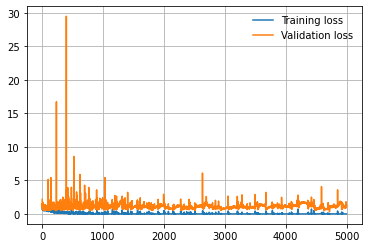

In [14]:
#training loss와 validation loss를 그래프로 표현합니다.
train_losses = train_losses
valid_losses = valid_losses

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses,label='Validation loss')
plt.legend(frameon=False)
plt.grid(True)

In [15]:
model_transfer.load_state_dict(torch.load(save_transfer)) #학습 종료 후 저장된 모델을 다시 로드하는 부분입니다.

<All keys matched successfully>

In [16]:
### TEST 기능입니다

def test(test_loader, model, criterion, use_cuda):
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    test_loss = 0.0
    accuracy = 0
    if use_cuda:
        model = model.cuda()
    model.eval()
    with torch.no_grad(): 
        for data, target in test_loader:
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss
            _, pred = torch.max(output, 1)    
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy())  if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
            
            for i in range(2): #batch-size에 따라 조절하시면 됩니다.
                label = target[i].data
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))
    print('\n')
    for i in range(2):
        print('Accuracy of %5s : %2d %% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
            

In [17]:
### TEST 기능입니다

def test(test_loader, model, criterion, use_cuda):
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    test_loss = 0.0
    accuracy = 0
    if use_cuda:
        model = model.cuda()
    model.eval()
    with torch.no_grad(): 
        for data, target in test_loader:
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss
            _, pred = torch.max(output, 1)    
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy())  if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
            
            label = target.data
            class_correct[label] += correct.item()
            class_total[label] += 1

    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))
    print('\n')
    for i in range(2):
        print('Accuracy of %5s : %2d %% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
            

In [18]:
test_batches = torch.utils.data.DataLoader(testing, batch_size=1,num_workers=0,pin_memory=True)

In [19]:
len(test_batches)

23

In [20]:
classes = ('Negative','Positive')
test(test_batches, model_transfer, criterion_transfer, use_cuda) #저는 가장 잘 나왔을때 평균 82%까지 나왔습니다. 노트북으로 돌리는 바람에 vram 부족으로 여러 조합을 실시해보지는 못했으나 여러 조합으로 튜닝해보시면 결과가 더 잘 나올것 같습니다.

Test Loss: 1.438536


Test Accuracy (Overall): 56% (13/23)


Accuracy of Negative : 100 % (11/11)
Accuracy of Positive : 16 % ( 2/12)
